In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import anndata as ad
import cellcharter as cc
import scvi
import matplotlib as mpl
import squidpy as sq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap

 captum (see https://github.com/pytorch/captum).
Global seed set to 0


In [3]:
ATAC_NAME = 'P22_mouse_brain_scVI_atac_ratio0.01_nlatent18_nlayers1'
RNA_NAME = 'P22_mouse_brain_scVI_rna_hvgs5000_nlatent18_nlayers2'

K=10

In [4]:
adata_ATAC = ad.read_h5ad('data/ATAC-RNA_mouse_brain/P22_mouse_brain_scVI_atac/adata.h5ad')
adata_RNA = ad.read_h5ad('data/ATAC-RNA_mouse_brain/P22_mouse_brain_scVI_rna/adata.h5ad')

In [5]:
adata = ad.concat([adata_RNA, adata_ATAC], axis=1, merge='same')

In [6]:
adata.obs['sample'] = 'P22_mouse_brain'
adata.obs['sample'] = pd.Categorical(adata.obs['sample'])
adata.obsm['spatial'][:, 1] = np.max(adata.obsm['spatial'][:, 1]) - adata.obsm['spatial'][:, 1]
adata.uns['spatial'] = {s: {} for s in adata.obs['sample'].unique()}
sq.gr.spatial_neighbors(adata, library_key='sample', coord_type='grid', n_neighs=4, n_rings=1)

# ATAC

In [7]:
adata_ATAC = adata[:, adata.var['modality'] == 'Peaks'].copy()

In [8]:
model_ATAC = scvi.model.SCVI.load('data/ATAC-RNA_mouse_brain/P22_mouse_brain_scVI_atac', adata=adata_ATAC)

INFO     File data/ATAC-RNA_mouse_brain/P22_mouse_brain_scVI_atac/model.pt already downloaded                      


In [9]:
adata_ATAC.obsm['X_scVI'] = model_ATAC.get_latent_representation()

In [10]:
cc.gr.aggregate_neighbors(adata_ATAC, n_layers=4, use_rep='X_scVI')

100%|██████████| 5/5 [00:00<00:00, 125.63it/s]


In [11]:
autok_ATAC = cc.tl.ClusterAutoK.load('data/ATAC-RNA_mouse_brain/P22_mouse_brain_scVI_atac_autok')

In [12]:
autok_ATAC.best_models[K].trainer_params['accelerator'] = 'cpu'
adata_ATAC.obs['cluster_cellcharter'] = autok_ATAC.predict(adata_ATAC, use_rep='X_cellcharter', k=K)

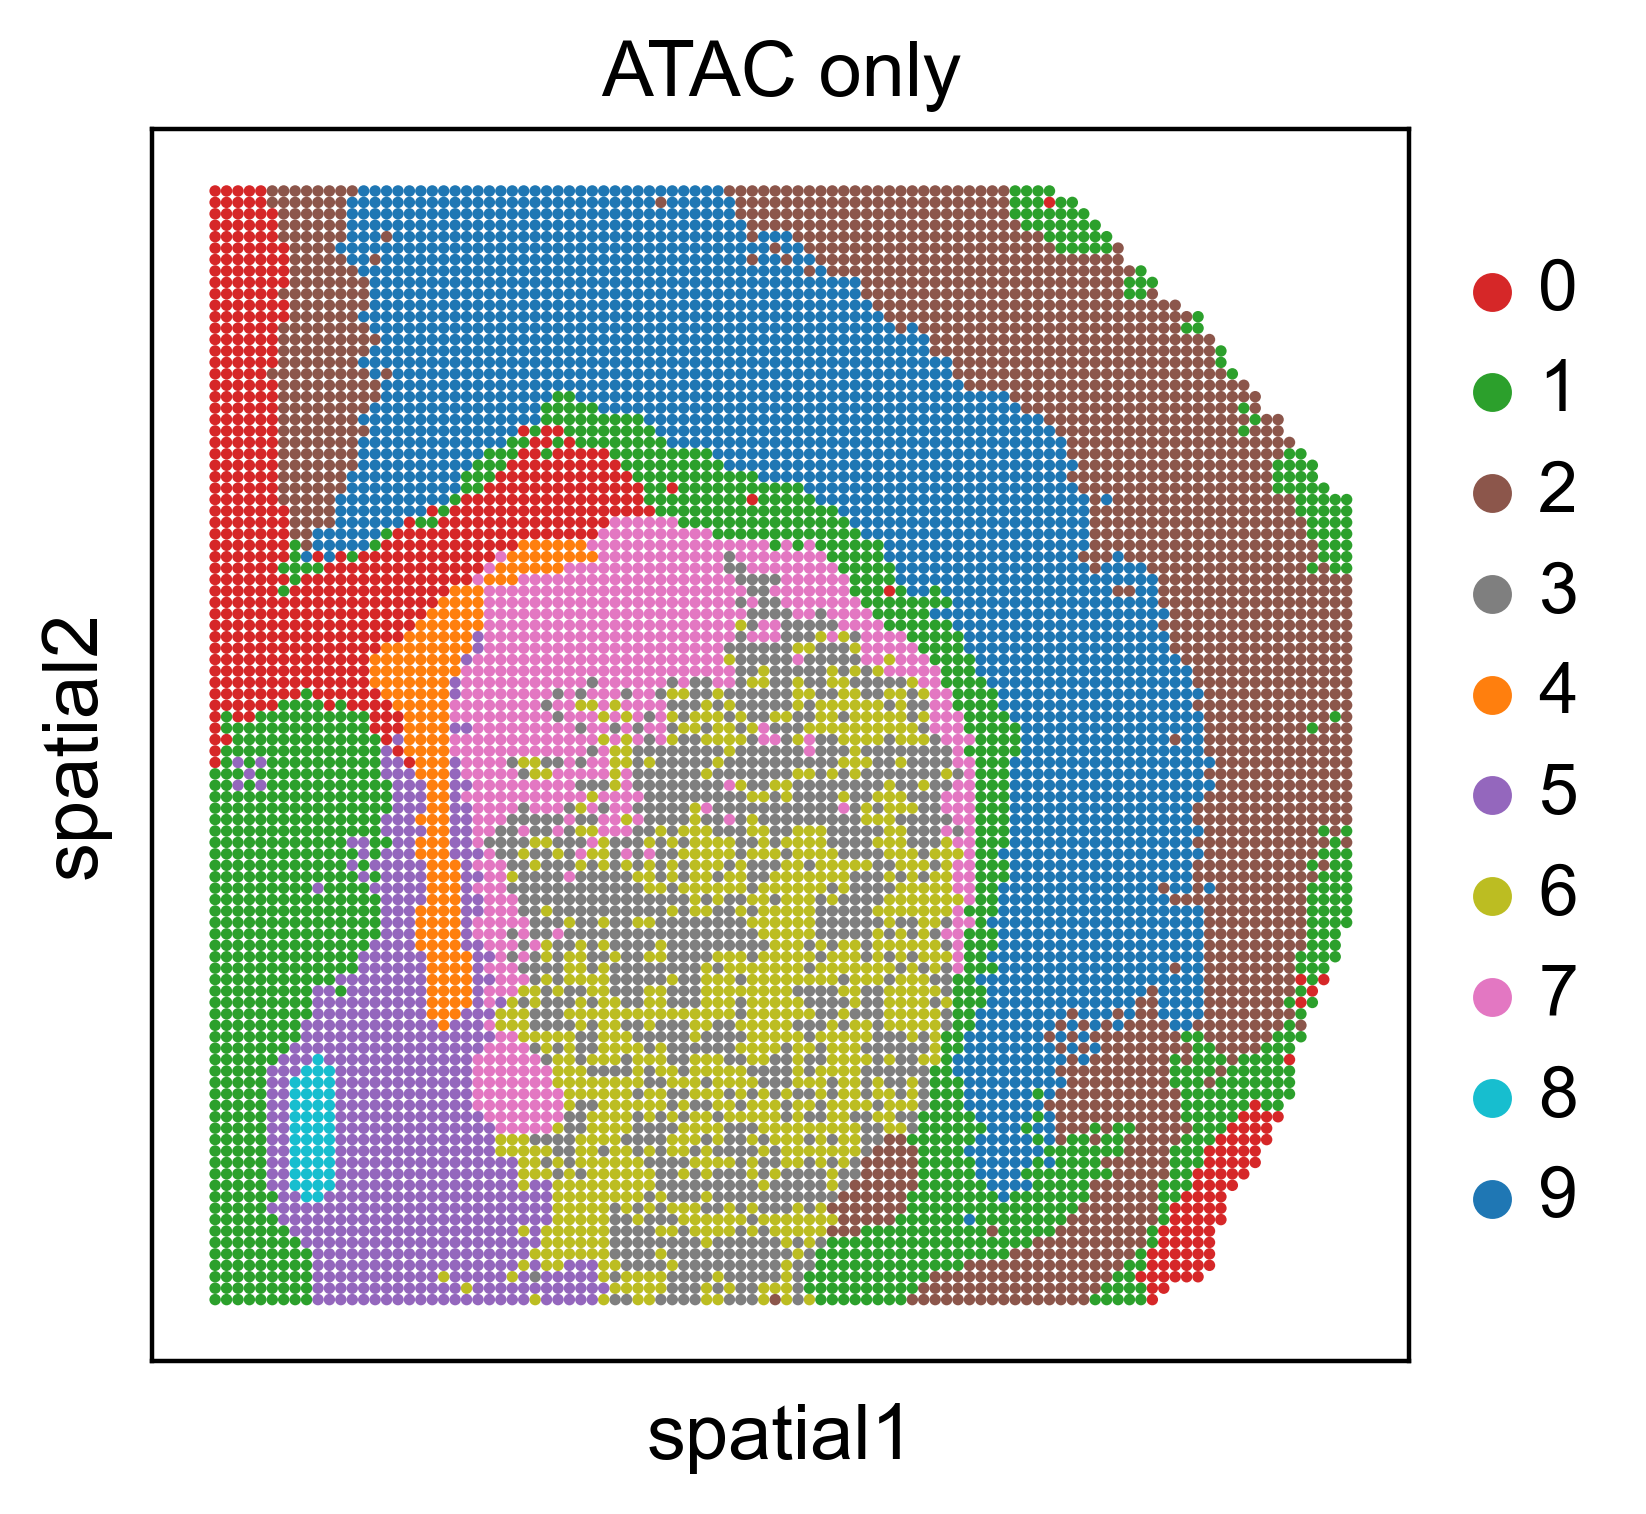

In [13]:
colormap_dict = {
    0: '#d62728',
    1: '#2ca02c',
    2: '#8c564b',
    3: '#7f7f7f',
    4: '#ff7f0e',
    5: '#9467bd',
    6: '#bcbd22',
    7: '#e377c2',
    8: '#17becf',
    9: '#1f77b4',
}

sq.pl.spatial_scatter(
    adata_ATAC, 
    color='cluster_cellcharter', 
    library_key='sample',  
    size=0.5, 
    img=None,
    palette=ListedColormap(colormap_dict.values()),
    title='ATAC only',
    library_id=adata_ATAC.obs['sample'].unique(),
)

# RNA

In [14]:
adata_RNA = adata[:, adata.var['modality'] == 'Gene Expression'].copy()

In [15]:
model_RNA = scvi.model.SCVI.load('data/ATAC-RNA_mouse_brain/P22_mouse_brain_scVI_rna', adata=adata_RNA)

INFO     File data/ATAC-RNA_mouse_brain/P22_mouse_brain_scVI_rna/model.pt already downloaded                       


In [16]:
adata_RNA.obsm['X_scVI'] = model_RNA.get_latent_representation()

In [17]:
cc.gr.aggregate_neighbors(adata_RNA, n_layers=4, use_rep='X_scVI')

100%|██████████| 5/5 [00:00<00:00, 147.51it/s]


In [18]:
autok_RNA = cc.tl.ClusterAutoK.load('data/ATAC-RNA_mouse_brain/P22_mouse_brain_scVI_rna_autok')

In [19]:
autok_RNA.best_models[K].trainer_params['accelerator'] = 'cpu'
adata_RNA.obs['cluster_cellcharter'] = autok_RNA.predict(adata_RNA, use_rep='X_cellcharter', k=K)

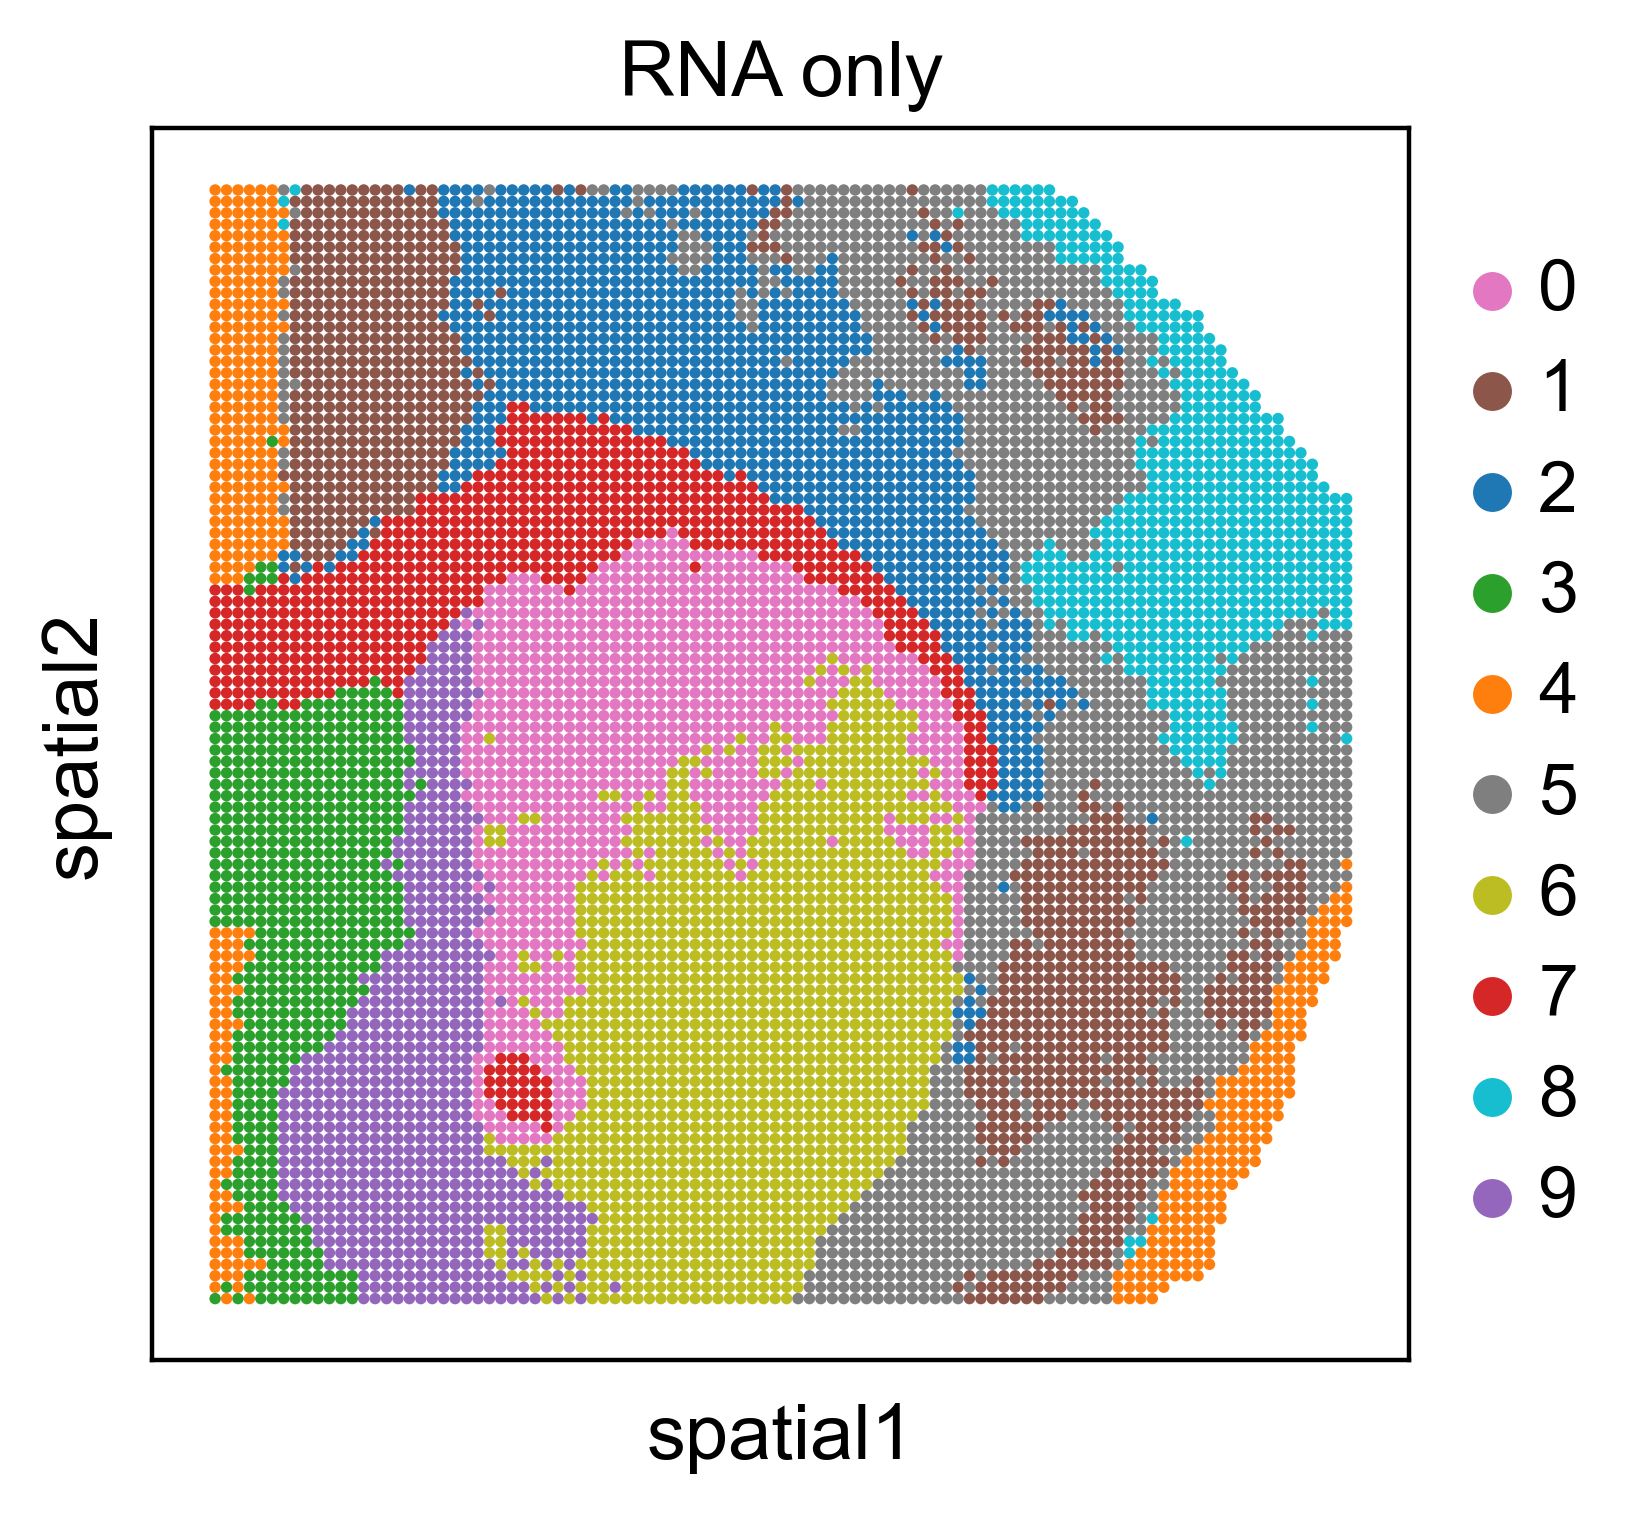

In [20]:
colormap_dict = {
    0: '#e377c2',
    1: '#8c564b',
    2: '#1f77b4',
    3: '#2ca02c',
    4: '#ff7f0e',
    5: '#7f7f7f',
    6: '#bcbd22',
    7: '#d62728',
    8: '#17becf',
    9: '#9467bd',
}

sq.pl.spatial_scatter(
    adata_RNA, 
    color='cluster_cellcharter', 
    library_key='sample',  
    size=0.5, 
    img=None,
    palette=ListedColormap(colormap_dict.values()),
    title='RNA only',
    library_id=adata_RNA.obs['sample'].unique(),
)

# ATAC + RNA

In [21]:
adata.obsm['X_scVI'] = np.concatenate([adata_RNA.obsm['X_scVI'], adata_ATAC.obsm['X_scVI']], axis=1)

In [22]:
cc.gr.aggregate_neighbors(adata, n_layers=4, use_rep='X_scVI')

100%|██████████| 5/5 [00:00<00:00, 129.72it/s]


In [23]:
autok = cc.tl.ClusterAutoK.load('data/ATAC-RNA_mouse_brain/P22_mouse_brain_scVI_atac-rna_autok')

In [24]:
autok.best_models[K].trainer_params['accelerator'] = 'cpu'
adata.obs['cluster_cellcharter'] = autok.predict(adata, use_rep='X_cellcharter', k=K)

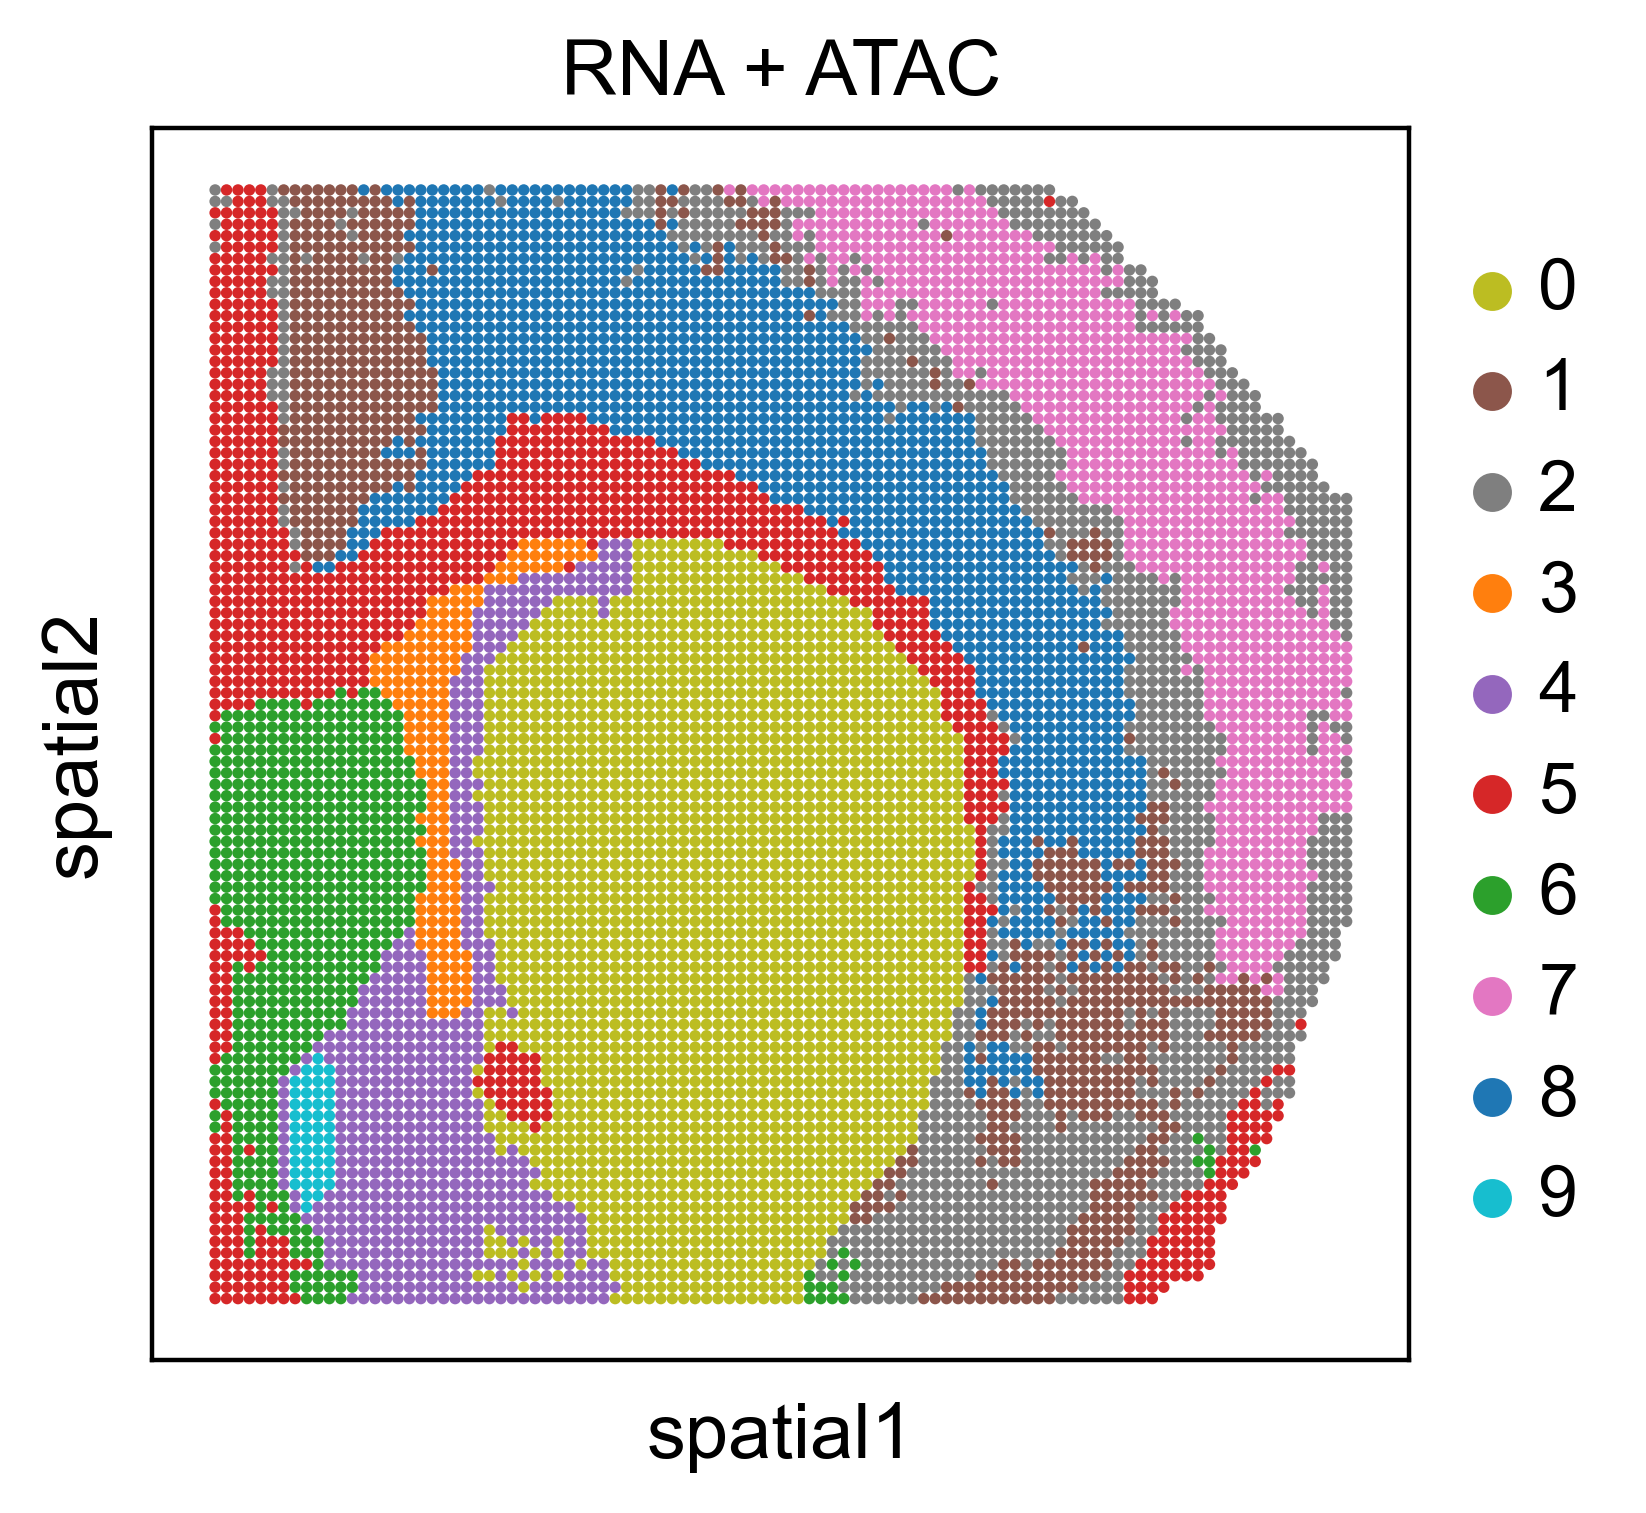

In [25]:
colormap_dict = {
    0: '#bcbd22',
    1: '#8c564b', 
    2: '#7f7f7f',
    3: '#ff7f0e', 
    4: '#9467bd',
    5: '#d62728',
    6: '#2ca02c', 
    7: '#e377c2', 
    8: '#1f77b4', 
    9: '#17becf',
}

sq.pl.spatial_scatter(
    adata, 
    color='cluster_cellcharter', 
    library_key='sample',  
    size=0.5, 
    img=None,
    palette=ListedColormap(colormap_dict.values()),
    title='RNA + ATAC',
    library_id=adata.obs['sample'].unique(),
)